In [1]:
import torch, io, datasets, PIL.Image,  numpy as np, json
from throughput.image import wallclock
from huggingface_hub import hf_hub_download
from types import SimpleNamespace
from walloc import walloc
from walloc.walloc import latent_to_pil, pil_to_latent
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor, resize

dataset = datasets.load_dataset("danjacobellis/kodak")
config_file = hf_hub_download(
    repo_id="danjacobellis/walloc",
    filename="RGB_16x.json"
)
codec_config = SimpleNamespace(**json.load(open(config_file)))
checkpoint_file = hf_hub_download(
    repo_id="danjacobellis/walloc",
    filename="RGB_16x.pth"
)
checkpoint = torch.load(checkpoint_file, map_location="cpu",weights_only=False)
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
dtype = torch.float

C:\Users\danja\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_wavelets\dtcwt\coeffs.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


RGB_16x.json:   0%|          | 0.00/388 [00:00<?, ?B/s]

RGB_16x.pth:   0%|          | 0.00/228M [00:00<?, ?B/s]

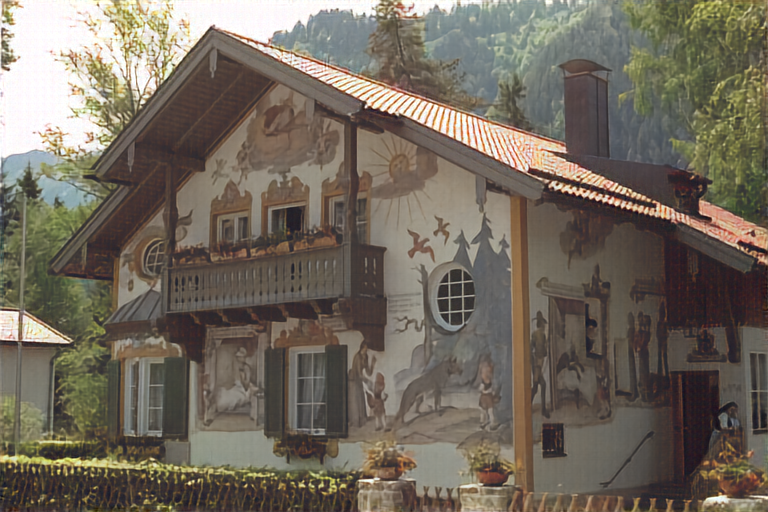

analysis: median=10.29ms, mean=17.91ms, throughput=38.23 MP/s
transfer: median=0.68ms, mean=0.73ms, throughput=574.04 MP/s
store: median=52.01ms, mean=54.67ms, throughput=7.56 MP/s
encode: median=64.24ms, mean=73.36ms, throughput=6.12 MP/s
decode: median=20.82ms, mean=44.45ms, throughput=18.88 MP/s


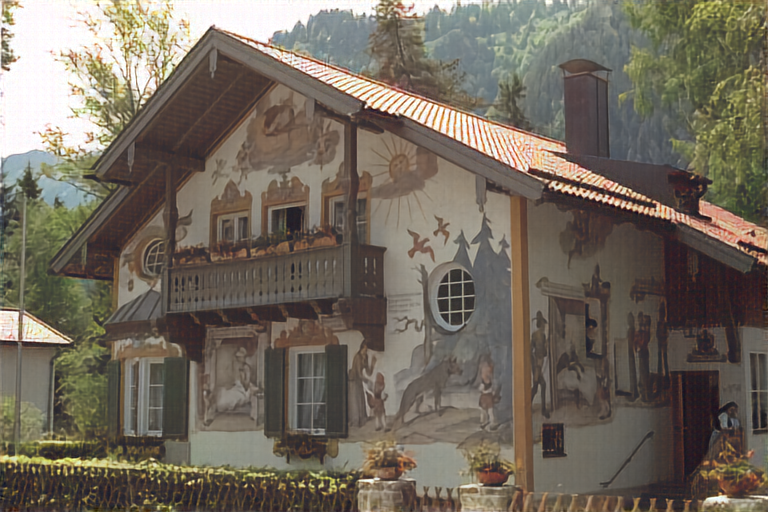

analysis: median=31.80ms, mean=34.72ms, throughput=12.37 MP/s
transfer: median=0.01ms, mean=0.01ms, throughput=41610.10 MP/s
store: median=43.71ms, mean=46.87ms, throughput=9.00 MP/s
encode: median=75.90ms, mean=81.64ms, throughput=5.18 MP/s
decode: median=2690.20ms, mean=2723.71ms, throughput=0.15 MP/s


In [2]:
for device in ['xpu','cpu']:
    wallclock.reset()
    codec.to(device)


    for _ in range(5):
        for sample in dataset['validation']:
            
            img = sample['image']
            x = pil_to_tensor(img).unsqueeze(0).to(dtype) / 127.5 - 1.0
            x = x.to(device)
            
            with wallclock('encode'):
                with wallclock('analysis'):
                    with torch.inference_mode():
                        x = codec.encoder(codec.wavelet_analysis(x,J=codec.J))

                with wallclock('transfer'):
                    x = x.cpu()
                    
                with wallclock('store'):
                    x = latent_to_pil(x, n_bits=8, C=3)[0]
                    buff = io.BytesIO()
                    x.save(buff, format='WEBP', lossless=True)
                
            with wallclock('decode'):
                x = pil_to_latent([PIL.Image.open(buff)], N=codec_config.latent_dim, n_bits=8, C=3).to(device).to(dtype)        
                x = x.to(device)
                with torch.no_grad():
                    x = codec.wavelet_synthesis(codec.decoder(x),J=codec.J).clamp(-1,1)
            
    display(to_pil_image(x[0]/2+0.5))
    wallclock.summary(pixels=512*768)